<h1>Chasing the Zeitegeist:<br>
Do Pitchfork Review Scores Have an Effect on Last.FM Album Playcounts?<br><br>
An Exploratory Data Analysis</h1>

<h3>By Jonah Blumstein, September 2016</h3>

<h2>Index</h2>
<ol>
<li><a href="#findings">TLDR; the Findings</a></li>
<li><a href="#introduction">Introduction</a></li>
<li><a href="#gettingthedate">Getting the Data</a></li>
<li><a href="#univariate">Univariate Analysis and Feature Exploration</a></li>
<li><a href="#time">Adding in Time</a></li>
<li><a href="#bivariate">Bivariate Analysis</a></li>
<li><a href="#ancova">Conducting and Interpreting the ANCOVA</a></li>
</ol>

<h2><a id="findings">TLDR; the Findings</a></h2>

All other factors considered:

<ul>
<li>A 1 point increase in Pitchfork review score has a median effect of +11% on Last.FM playcount.</li>
<li>An album release date one year later has a median effect of 20% on Last.FM plays per day.</li>
<li>Genre is a major influence on Last.FM Playcount; pop albums are expected to receive a median of 8 times as many plays as experimental albums.</li>
</ul>

<h2><a id="introduction">Introduction</a></h2>

<p>Pitchfork is a music review website that began in the late 1990s. For the past two decades, Pitchfork has been reviewing albums on a 0.0-10.0 scale, with review scores in 0.1 point increments.</p>

<p>Pitchfork is perceived to be a tastemaker, making or breaking the careers of many musicians.</p>

<p>But just how influential is it really, especially compared to other factors like genre?</p>

<p>These are some of the questions that I will answer here. To measure a Pitchfork review score's explanatory ability, I will be looking at playcount and genre data from Last.FM, a music data provider that has been collecting playcount data from a number of different online streaming services and album metadata since 2002.</p>

<p>This analysis will lead up to an ANCOVA (an ANOVA with one or more continuous variables), with a dependent variable of playcount, categorical independent variable of genre, and independent continuous variables of Pitchfork rating and days since album release.</p>

<p>Let's get started.</p>


<h2><a id="gettingthedate">Getting the Data</a></h2>

<p>The first step to data analysis is of course obtaining the data. Prior to a recent reorganization of the Pitchfork site after their acquisition by Conde Nast, a list of review index pages was presented in semantic, consistent HTML and CSS. I built a scraper (<a href="https://gist.github.com/JBlumstein/d475f62e686e0d55ab56dae1a0503211">script on gist</a>), to get review data, including artist, album name, review date, and review scores for all album reviews between early 2001 and early 2016 (right before the site change).</p>

<p>I then ran the Pitchfork album review data through the Last.FM API (<a href="https://gist.github.com/JBlumstein/2d8d69652ad34f9a9c6766ceb3fc4630">script on gist</a>) to build a larger dataset that includes album level data on number of songs, album duration in seconds, number of plays on Last.FM, number of listeners on Last.FM, and genres.</p>


<h3>A first look</h3>

<p>Here's an initial look at the data set (the first 5 of 16720 reviews), after it's been run through the Last.FM API. I've also imported the relevant packages for this analysis in the same step.</p>

In [243]:
#import packages
import numpy as np
import pandas as pd
from datetime import datetime
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display

#read in
df = pd.read_csv("http://jonahblumstein.ipower.com/pfkreviewsstore.csv")

#view first five lines
df[0:5]

,Rating,Artist,Album,Date,Listeners,Playcount,NumSongs,Duration,Genre1,Genre2,Genre3,Genre4,Genre5
0,5.9,Willard Grant Conspiracy,Everything's Fine,3/31/2001,1740.0,27276.0,11.0,2471.0,americana,NaN,NaN,NaN,NaN
1,8.5,The Soft Boys,Underwater Moonlight,3/31/2001,49453.0,532944.0,18.0,4134.0,1980,post-punk,new wave,80s,rock
2,8.8,Autechre,Confield,4/17/2001,59695.0,708714.0,10.0,4332.0,idm,electronic,experimental,abstract,ambient
3,8.3,Bows,Cassidy,4/16/2001,2159.0,39419.0,12.0,4379.0,NaN,NaN,NaN,NaN,NaN
4,8.0,Red House Painters,Old Ramon,4/10/2001,35898.0,493434.0,10.0,4297.0,slowcore,4ad,indie rock,2001,slow alternative


<h2><a id="univariate">Univariate Analysis and Feature Exploration</a></h2>

<p>Now that the data set is in place, the correct features need to be set up, especially around our dependent variable of playcount and our independent variables of genre and Pitchfork rating.</p>

<p>A few places to start:

<ul>

<li>Consistent genre names: hip-hop, hip hop, and Hip Hop (an example of three genres that fall under genres 1 through 5 in the data set), need to be lumped into one set.</li>

<li>Useable date formats: a Year feature needs to be created from the last four digits in date, the Date feature needs to be converted from string to datetime format, and Month periods need to be created.</li>

</ul>

In [186]:
#fix genres
df['Genre1']=df['Genre1'].str.strip().str.lower().str.replace('-', ' ')
df['Genre2']=df['Genre2'].str.strip().str.lower().str.replace('-', ' ')
df['Genre3']=df['Genre3'].str.strip().str.lower().str.replace('-', ' ')
df['Genre4']=df['Genre4'].str.strip().str.lower().str.replace('-', ' ')
df['Genre5']=df['Genre5'].str.strip().str.lower().str.replace('-', ' ')

#create year column and fill as last four characters from 'Date' string and set as int
df['Year'] = df['Date'].str[-4:].astype(int)

#set 'Date' column as datetime format
df['Date'] = pd.to_datetime(df['Date'])

#create month column using datetime periods
df['MonthP'] = df['Date'].dt.to_period('M')

<p>With these issues solved, the univaraiate analyses can begin.</p>

<h3>Univariate Analysis: Genre</h3>

<p>The Last.FM data set includes up to 5 genres per album, listed as Genre1, Genre2, Genre3, Genre4, and Genre5. In most instances, it's easier to work with dummy variables for the most common genres instead of lists broken up between up to five cells in the dataframe. Which genres appear most frequently can be estimated by taking a look at top genres in Genre1.</p>

In [187]:
#album_count variable for aggregation, all_albums for when we want to look at all albums (same thing, different use cases)
df['album_count'] = int(1)
df['all_albums'] = int(1)

#view top genres by frequency
df.groupby(['Genre1']).count().sort_values('album_count',ascending=False).loc[:,['album_count']].reset_index()[0:5]

,Genre1,album_count
0,albums i own,809
1,indie,494
2,2013,422
3,electronic,402
4,2014,390


<p>This list can then be used to inform a decision on what genres to create dummy variables around. <b>Note that this step takes a minute or two to run.</b></p>

In [188]:
#feature creation around genre
#this takes a minute or two

mygenres = ['indie','electronic','hip hop','indie rock','folk','rock','ambient','experimental','post rock','rap','indie pop','noise','jazz','black metal','post punk','idm','alternative','shoegaze','pop','electronica','singer songwriter','punk','noise rock','psychedelic','soul','female vocalists','dubstep','instrumental','techno','alternative rock','trip hop','lo fi','americana','math rock','electro','dream pop','progressive rock','classic rock','blues','r&b','emo','hardcore']

def addGenre(dfRow,genre):
    if (dfRow['Genre1'] == genre):
        return 1
    elif (dfRow['Genre2'] == genre):
        return 1
    elif (dfRow['Genre3'] == genre):
        return 1
    elif (dfRow['Genre4'] == genre):
        return 1
    elif (dfRow['Genre5'] == genre):
        return 1
    else:
        return 0

for genre in mygenres: 
    df[genre]=df.apply(addGenre, genre=genre, axis=1)

<p>In order to make genre information easier to work with, genres can be lumped into clusters. This way, the analysis is narrowed down from about 50 genres to 9 clusters, each with at least a couple hundred reviews. <b>This step also takes a minute or two to run.</b></p>

In [189]:
#function for creating clustered genres
#this also takes a minute or so

def createGenreCluster(dfRow, clusterGenres):
    for genre in clusterGenres:
        if dfRow[genre]==1:
            return 1
            break
    return 0

#create clusters
df['urban_cluster']=df.apply(createGenreCluster, clusterGenres=['hip hop', 'rap', 'r&b', 'soul'], axis=1)
df['classic_rock_cluster']=df.apply(createGenreCluster, clusterGenres=['progressive rock', 'psychedelic', 'classic rock'], axis=1)
df['traditional_cluster']=df.apply(createGenreCluster, clusterGenres=['folk', 'americana', 'singer songwriter'], axis=1)
df['electronic_cluster']=df.apply(createGenreCluster, clusterGenres=['idm', 'electro', 'electronica', 'techno', 'dubstep'], axis=1)
df['alternative_cluster']=df.apply(createGenreCluster, clusterGenres=['alternative', 'alternative rock'], axis=1)
df['pop_cluster']=df.apply(createGenreCluster, clusterGenres=['pop'], axis=1)
df['punk_cluster']=df.apply(createGenreCluster, clusterGenres=['punk', 'post punk', 'math rock', 'emo', 'hardcore'], axis=1)
df['indie_cluster']=df.apply(createGenreCluster, clusterGenres=['indie rock', 'lo fi', 'dream pop', 'shoegaze', 'trip hop', 'indie', 'indie pop'], axis=1)
df['experimental_cluster']=df.apply(createGenreCluster, clusterGenres=['post rock', 'ambient', 'experimental', 'instrumental', 'noise', 'noise rock'], axis=1)

#get list of clusters with underscores
clusters = ['urban_cluster','classic_rock_cluster','traditional_cluster','electronic_cluster','indie_cluster','alternative_cluster','pop_cluster','punk_cluster','experimental_cluster']

def groupsTable(groups):
    #get and print all summary info by cluster

    mylist = list()
    
    for group in groups:
        albums = df[df[group] == 1]
        numberAlbums = len(albums)
        mylist.append((group,numberAlbums))    
    info=['group','numberAlbums']
    df_by_group = pd.DataFrame(mylist,columns=info)
    
    return df_by_group

clustersTable = groupsTable(clusters)
clustersTable

,group,numberAlbums
0,urban_cluster,788
1,classic_rock_cluster,358
2,traditional_cluster,789
3,electronic_cluster,744
4,indie_cluster,2823
5,alternative_cluster,895
6,pop_cluster,312
7,punk_cluster,476
8,experimental_cluster,1543


<h3>Univariate Analysis: Pitchfork Review Rating</h3>

<p>Next, the other independent variables for review rating should be looked at. A basic histogram of ratings is below.</p>

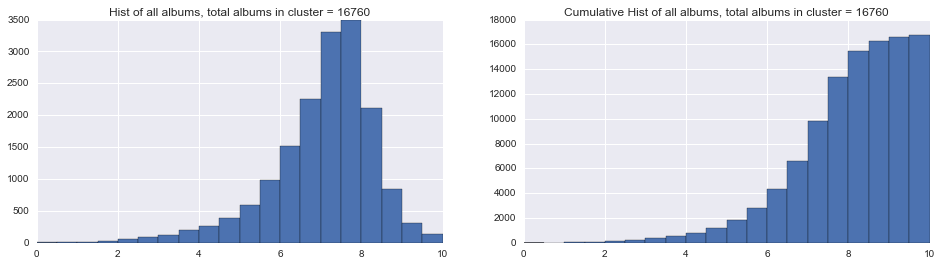

In [190]:
def makeHists(cluster):

    #create matplotlib figure
    fig = plt.figure(figsize=(16,4))
    
    #first hist is regular hist
    ax1 = fig.add_subplot(1,2,1)
    albums = df[df[cluster] == 1]
    album_ratings = albums['Rating']
    if cluster == 'album_count':
        title = "Hist of all albums, total albums in cluster = " + str(len(albums))
    else:
        title = "Hist of " + str(cluster) + ", total albums in cluster = " + str(len(albums))
    ax1.set_title(title)
    ax1.hist(album_ratings,bins=20,range=(0.0,10.0))
    
    #second hist is cumulative hist
    ax2 = fig.add_subplot(1,2,2)
    if cluster == 'album_count':
        title = "Cumulative Hist of all albums, total albums in cluster = " + str(len(albums))
    else:
        title = "Cumulative Hist of " + str(cluster) + ", total albums in cluster = " + str(len(albums))
    ax2.set_title(title)
    ax2.hist(album_ratings,bins=20,range=(0.0,10.0),cumulative=True)
    
makeHists('album_count')

<p>The histogram shows clear signs of skewness, with a long left tail. As a result, standard deviations are misleading, and more general measures like quantiles should be relied upon instead.</p>

<p>Here we see that the median Pitchfork rating is 7.2, the 25th and 75th percentiles are 6.4 and 7.8, and the 5th and 9th percentiles are 4.5. The 5th and 95th percentiles in particular reflect the left skew of the distribution, with the 5th percentile equal to the median - 2.7, and the 95th percentile equal to the median + 1.4 (e.g. the 5th percentile rating is twice as far from the median rating as the 95th percentile rating).</p> 

In [192]:
def groupsPercentilesTable(groups):
    #get and print all summary info by cluster

    list_for_all_groups = list()
    
    percentiles = [5,10,25,50,75,90,95]
    
    for group in groups:
        list_for_group = list()
        list_for_group.append(group)
        albums = df[df[group] == 1]
        for j in percentiles:
            pc = round(np.percentile(albums['Rating'],j),1)
            list_for_group.append(pc)
        
        list_for_all_groups.append(list_for_group)
    
    colnames = ['group']
    for k in percentiles:
        colname = str(k) + 'th Percentile'
        colnames.append(colname)

    df_by_group_and_decile = pd.DataFrame(list_for_all_groups,columns=colnames)
    
    return df_by_group_and_decile

PercentilesTable = groupsPercentilesTable(['all_albums'])
PercentilesTable

,group,5th Percentile,10th Percentile,25th Percentile,50th Percentile,75th Percentile,90th Percentile,95th Percentile
0,all_albums,4.5,5.3,6.4,7.2,7.8,8.3,8.6


<h3>Univariate Analysis: Playcount</h3>

<p>Now on to playcount. Again, creating a histogram of values is the first step. In order to deal with NANs, the histogram only uses entries where the playcount value is finite.</p>

(array([  1.34700000e+04,   4.67000000e+02,   1.54000000e+02,
          8.80000000e+01,   5.70000000e+01,   3.30000000e+01,
          1.80000000e+01,   1.80000000e+01,   1.00000000e+01,
          1.40000000e+01,   2.00000000e+00,   7.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00]),
 array([        0.,   3610835.,   7221670.,  10832505.,  14443340.,
         18054175.,  21665010.,  25275845.,  28886680.,  32497515.,
         36108350.,  39719185.,  43330020.,  46940855.,  50551690.,
         54162525.,  57773360.,  61384195.,  64995030.,  68605865.,
         72216700.]),
 <a list of 20 Patch objects>)

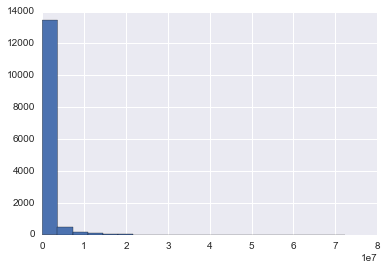

In [193]:
plt.hist(df[np.isfinite(df.Playcount)]['Playcount'],bins=20)

<p>Clearly, this variable should be log scaled. For this histogram, albums that do not have full entries (as measured by having at least one genre tag) in Last.FM are also removed, as these albums are likely not accessible to the services Last.FM follows.</p>

<p>The resulting histogram happily suggests a great deal of normality, albeit with a bit of a long left tail.</p>

(array([    5.,     4.,    10.,    18.,    21.,    37.,    35.,    69.,
          171.,   354.,   758.,  1351.,  1646.,  1630.,  1466.,   988.,
          694.,   366.,   155.,    41.]),
 array([ 0.47712125,  0.84619707,  1.21527289,  1.58434871,  1.95342453,
         2.32250035,  2.69157617,  3.06065199,  3.42972781,  3.79880363,
         4.16787945,  4.53695527,  4.90603109,  5.2751069 ,  5.64418272,
         6.01325854,  6.38233436,  6.75141018,  7.120486  ,  7.48956182,
         7.85863764]),
 <a list of 20 Patch objects>)

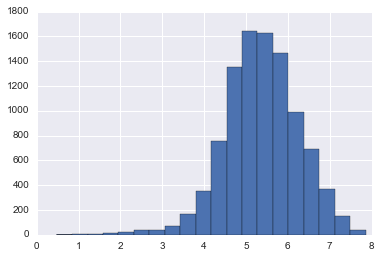

In [194]:
playcount_values = df[(np.isfinite(df.Playcount)) & (df['Playcount'] >= 1)].dropna(subset=['Genre1']).reset_index(drop=True)['Playcount']
plt.hist(np.log10(playcount_values),bins=20)

<p>Here is a table of key values for logged playcounts. Note that mean and median are quite close to one another, reinforcing the impression that logged playcount is normally distributed.</p>

In [216]:
playcounts = df[(np.isfinite(df.Playcount)) & (df['Playcount'] >= 1)].dropna(subset=['Genre1']).reset_index(drop=True)['Playcount']
log_playcounts = np.log10(playcounts)

n, min_max, mean, var, skew, kurt = stats.describe(log_playcounts)
median = log_playcounts.median()
std = var**.5
CIL = mean - 2*std
CIU = mean + 2*std
explain = ['median','mean','stdev','5th Percentile','95th Percentile']
descrip = [median,mean,std,CIL,CIU]

descrip_stats_table = pd.DataFrame(descrip,explain,columns=['log_playcount'])

descrip_stats_table

,log_playcount
median,5.362345
mean,5.368328
stdev,0.896029
5th Percentile,3.576271
95th Percentile,7.160386


<h2><a id="time">Adding in Time</a></h2>

<p>While time on its own is not so interesting a variable, when mixed with the other variables, it can be have a significant impact on analyses. Therefore, it must considered.</p>

<p>Here's a graph of the number of albums Pitchfork reviewed in each year. The 2002 figure is for 10 months. 2016 is excluded in the count chart because there are only have two and a half months of ratings for the year.</p>

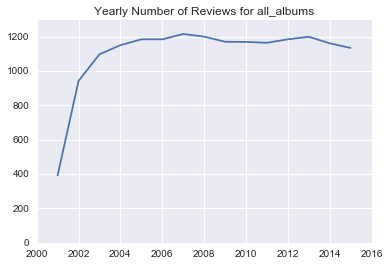

In [54]:
def makeReviewsPerYearPlot(mydf,group,divisor,title):
    time_fig = plt.figure()
    #plot number of reviews per year
    yearly_number_ratings_plot = time_fig.add_subplot(1,1,1)
    yearly_number_ratings_plot.plot(mydf[mydf <= 2015].groupby(['Year'])[group].sum()/divisor)
    yearly_number_ratings_plot.set_ylim(bottom=0)
    yearly_number_ratings_plot.set_title(title + group)

makeReviewsPerYearPlot(df,'all_albums',1,'Yearly Number of Reviews for ')

<p>When time is combined with Pitchfork review ratings, however, the first major insight occurs: the distribution of ratings has gotten narrower, with the top scores decreasing and the lowest scores increasing over time.</p>

<p>This finding becomes clear when looking at a graph of quantiles over rolling 12 months periods. Despite only small fluctuations in median score, there are clear steady increases in the 5th percentile, which goes up from about 3.0-3.5 from 2002 to 2004 to above 5.0 from 2013 onwards, and clear steady decreases in the 95th percentile, which drops from 9.0 in 2002 to a about 8.5 in 2010, where it levels off.</p>


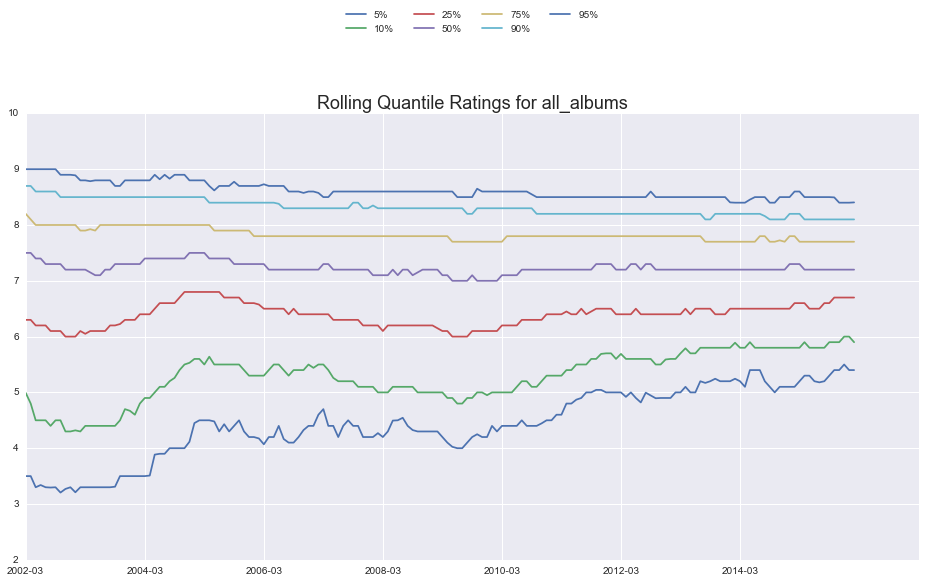

In [33]:
df['months_from_start'] = df['MonthP'] - df['MonthP'][0]

#function to create df with quantile values
def getTrailingQuantilesDF(group, quantiles, window_size, periods):

    one_group_df = df[df[group] == 1]
    
    all_quantile_vals = []
    
    #create list of column names for df
    quantile_names = []
    for quantile in quantiles:
        quantile_name = str(quantile) + '%'
        quantile_names.append(quantile_name)
    
    #create list of quantile values for each month then create df based on it
    for i in range(window_size,len(periods)):
        ratings = one_group_df[(one_group_df['months_from_start'] < i) & (one_group_df['months_from_start'] >= i - window_size)]['Rating']
        quantile_vals = []
        for quantile in quantiles:
            quantile_val = np.percentile(ratings,quantile)
            quantile_vals.append(quantile_val)
        all_quantile_vals.append(quantile_vals)
    quantiles_df = pd.DataFrame(all_quantile_vals, columns=quantile_names)

    #create a df with months
    months_df = pd.DataFrame(periods.tolist()[window_size:],columns=['Period Ending'])

    #create a df from months df and values df
    mergedDF = pd.concat([months_df,quantiles_df], axis=1, join_axes=[quantiles_df.index])
    
    return mergedDF, quantile_names, group


#function to create rolling quantiles graph
def makeRollingQuantilesGraph(rqs,qns,rqp,g,months_between_ticks):
    
    #plotting
    for i in range(1,len(rqs.columns)):
        rqp.plot(rqs.ix[:,i])
    
    #create ticks
    ticks = range(0,len(rqs),months_between_ticks)
    rqp.xaxis.set_ticks(ticks)
    
    #create axis tick labels that are date rather than album index
    x_axis_labels = []
    for tick in ticks:
        date = rqs.ix[tick,'Period Ending']
        x_axis_labels.append(date)
    rqp.set_xticklabels(labels = x_axis_labels)

    #set top and bottom of chart
    rqp.set_ylim(bottom=2.0)
    rqp.set_ylim(top=10.0)

    #set title
    rqp.set_title('Rolling Quantile Ratings for ' + str(g),fontsize=18)
    
    #set legend
    rqp.legend(qns, loc='upper center', ncol=4, bbox_to_anchor=[0.5,1.25], fancybox=True)
    
    
#parameters
pfk_period_range = pd.period_range(df['MonthP'][0], df['MonthP'][len(df['MonthP'])-1], freq='M')
pfk_quantiles = [5,10,25,50,75,90,95] #quartiles
num_months = 12 #number of months in rolling quantiles
g = 'all_albums' #what to call group being charted
f, rqplot = plt.subplots() #supblot rqplot in figure f
m_b_t = 24 #months between tick marks

#run functions to get rolling quantiles and create graph
tqdf, tqn, graph_title = getTrailingQuantilesDF(g, pfk_quantiles, num_months, pfk_period_range)
makeRollingQuantilesGraph(tqdf, tqn, rqplot, graph_title, m_b_t)


#resize figure
f.set_size_inches((16,8))

<p>We are now left with a question: is this relationship between release date and the distribution of Pitchfork ratings something we need to adjust for?</p>

<p>It's a question that leans heavily on interpretation. If the distribution of Pitchfork ratings changed because the types of albums reviewed changed (e.g. Pitchfork decided that terrible albums just weren't worth talking about and decided not to rate them), then an adjustment should not be added to the Pitchfork ratings variable. However, if the distribution of Pitchfork ratings changed because Pitchfork decided to change their rating criteria, than an adjustment should be made.</p>

<p>In a more in-depth analysis, an examination of multicollinearity would be need to be done here. But, ultimately it's hard to know what's going on without having information on Pitchfork's editorial standards over time that I don't have access to. As a result, I've decided to leave the Pitchfork rating variable unadjusted.</p>

<p>Moving on, by adding in time, the growth in Pitchfork review frequency of certain genres and a decrease in others can also be seen.</p>

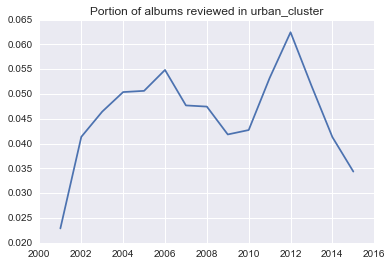

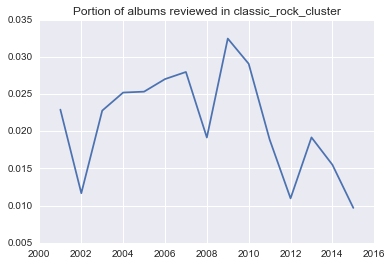

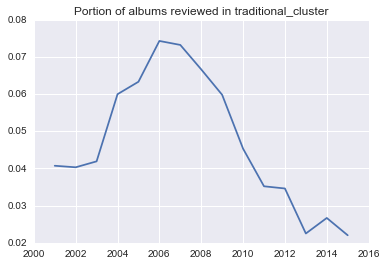

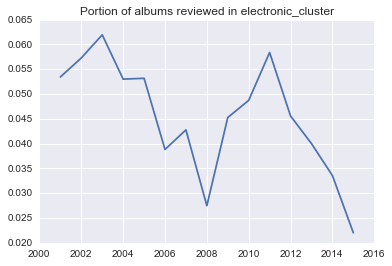

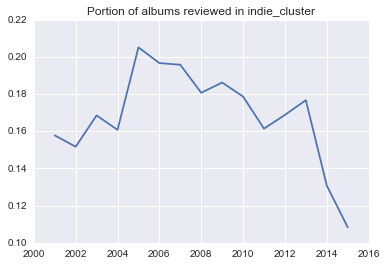

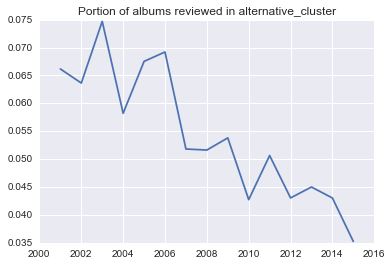

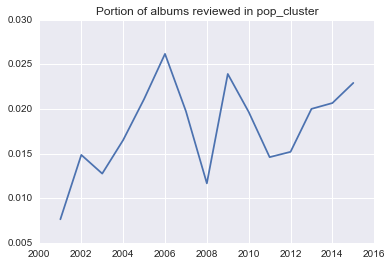

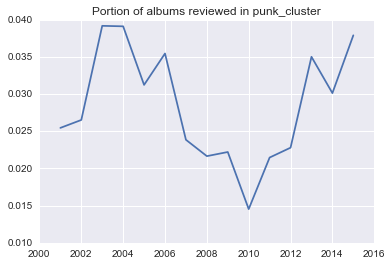

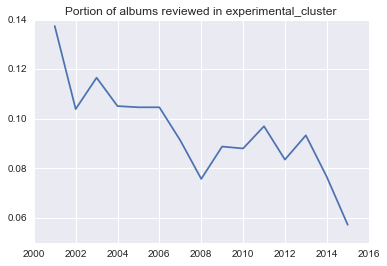

In [230]:
def makeReviewsPerYearPlot(df,group,data,plot_title):
    albums = df[(df[group]==1) & (df['Year'] <= 2015)]
    annual_num_albums = albums.groupby(['Year'])['all_albums'].sum()
    plt.plot(annual_num_albums/data)
    plt.title(plot_title)
    plt.show()

for cluster in clusters:
    title = 'Portion of albums reviewed in ' + str(cluster)
    makeReviewsPerYearPlot(df,cluster,df.groupby(['Year'])['all_albums'].sum(),title)

<p>Finally, playcount over time should be examined. Obviously, there is a trend towards greater playcount figures for older albums. This trend makes sense--older albums have had more time to accrue plays.</p>

<p>There is also a trend toward greater playcounts that ends in 2007. This could be for multiple reasons:</p>

<ul>
<li>The albums in the dataset are solely albums that Pitchfork has reviewed--changes in playcount could be due to changes in the kinds of albums Pitchfork reviews from more obsure to more mainstream albums.</li>
<li>Internet music listening grew rapidly in the early to mid-2000s.</li>
<li>Last.FM's complicated history of partnerships--for example the 2008 to 2014/2015 partnership with Spotify--could affect playcounts</li>
</ul>

<p>Simply, there are too many unknowns to grapple with or model here. The best that can be done is assume that these factors, in combination, are a wash.</p>

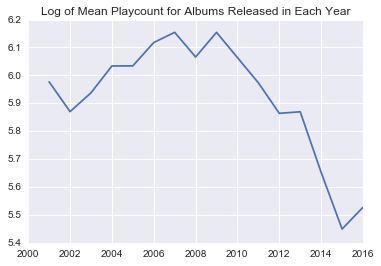

In [231]:
time_fig.clear()
time_fig = plt.figure()
yearly_number_ratings_plot = time_fig.add_subplot(1,1,1)
yearly_number_ratings_plot.plot(np.log10(df.groupby(df['Year'])['Playcount'].mean()))
yearly_number_ratings_plot.set_title('Log of Mean Playcount for Albums Released in Each Year')

<p>In any case, it is clear logged plays per day should be an independent variable, instead of logged total plays. Interestingly, logged plays per day appears to track with time since album release, with newer albums receiving a greater number of plays per day than older albums.</p>

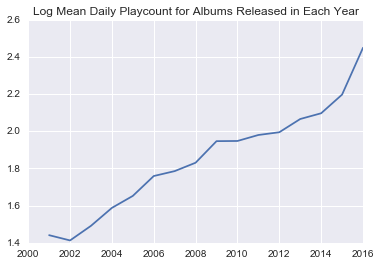

In [232]:
df3 = df[(np.isfinite(df.Playcount)) & (df['Playcount'] >= 1)].reset_index(drop=True)
df3['days_since_2016_06_22'] = pd.Period('2016-06-22') - df3['Date'].dt.to_period('D')

def addDaysDivisor(dfRow):
    return dfRow['days_since_2016_06_22']

df3['days_divisor']=df3.apply(addDaysDivisor, axis=1)

df3['playcount_per_day'] = df3['Playcount']/df3['days_divisor']

df3['log_playcount_per_day'] = np.log10(df3['playcount_per_day'])

def makeAveragePlaycountPerDayPlot(mydf,title):
    time_fig = plt.figure()
    #plot playcount per day for each year
    yearly_number_ratings_plot = time_fig.add_subplot(1,1,1)
    yearly_number_ratings_plot.plot(mydf[(np.isfinite(mydf.playcount_per_day)) & (mydf['playcount_per_day'] >= 1)]['log_playcount_per_day'].groupby(mydf['Year']).mean())
    yearly_number_ratings_plot.set_title(title)

makeAveragePlaycountPerDayPlot(df3,'Log Mean Daily Playcount for Albums Released in Each Year')

<h2><a id="bivariate">Bivariate Analysis:</a></h2>

<p>Before running the ANCOVA, analyses showing logged plays per day as a response for our independent variables should be performed.<p>

<p>Since work on date has already been started, it's a good first bivariate analysis to do.</p>

                              OLS Regression Results                             
Dep. Variable:     log_playcount_per_day   R-squared:                       0.061
Model:                               OLS   Adj. R-squared:                  0.061
Method:                    Least Squares   F-statistic:                     916.2
Date:                   Wed, 07 Sep 2016   Prob (F-statistic):          4.41e-195
Time:                           17:51:05   Log-Likelihood:                -24612.
No. Observations:                  14211   AIC:                         4.923e+04
Df Residuals:                      14209   BIC:                         4.924e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------


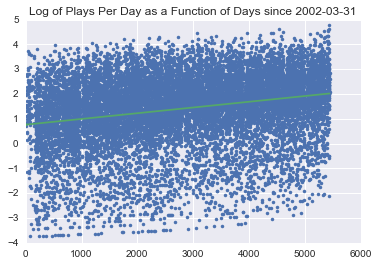

In [233]:
first_review_date = pd.Period(df3['Date'][0],freq='D')

def addDaysSinceFirstReview(dfRow,date_to_subtract):
    days = pd.Period(dfRow['Date'],freq='D') - date_to_subtract
    return days

df3['days_since_2002_03_31']=df3.apply(addDaysSinceFirstReview, date_to_subtract = first_review_date, axis=1)

formula = 'log_playcount_per_day ~ days_since_2002_03_31'
lm = ols(formula, df3)
fit = lm.fit()
intercept = fit.params[0]
slope = fit.params[1]
print(fit.summary())

plt.plot(df3['days_since_2002_03_31'], df3['log_playcount_per_day'], '.')
plt.plot(df3['days_since_2002_03_31'], slope*df3['days_since_2002_03_31'] + intercept, '-')
plt.title('Log of Plays Per Day as a Function of Days since 2002-03-31')

<p>Interestingly, there is a small r-value of .061, with a p-value well below .05 (which suggests statistical significance), and a slope that demonstrates an increase in logged daily plays of .000231 plays per day of album release.</p>

<p>In contrast, a linear regression of log plays per day as a result of Pitchfork Rating shows no correlation, with a very high p-value (0.44).</p>

                              OLS Regression Results                             
Dep. Variable:     log_playcount_per_day   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                 -0.000
Method:                    Least Squares   F-statistic:                    0.5938
Date:                   Wed, 07 Sep 2016   Prob (F-statistic):              0.441
Time:                           17:51:59   Log-Likelihood:                -25055.
No. Observations:                  14211   AIC:                         5.011e+04
Df Residuals:                      14209   BIC:                         5.013e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.3705 

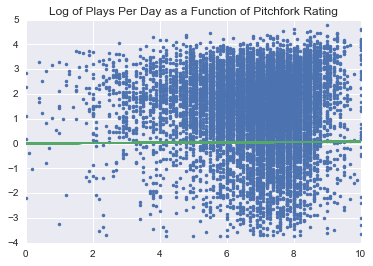

In [234]:
formula = 'log_playcount_per_day ~ Rating'
lm = ols(formula, df3)
fit = lm.fit()
intercept = fit.params[1]
slope = fit.params[1]
print(fit.summary())

plt.plot(df3['Rating'], df3['log_playcount_per_day'], '.')
plt.plot(df3['Rating'], slope*df3['Rating'] + intercept, '-')
plt.title('Log of Plays Per Day as a Function of Pitchfork Rating')

<p>Finally, plays per day as a response to genre cluster is examined. While the confidence intervals are very wide, it is notable that the means vary quite a bit by genre cluster, with pop having the highest average of logged plays per day and experimental having the fewest.<p>

In [235]:
df_filtered = df3.dropna(subset=['Genre1']).reset_index(drop=True)

rating_vals = []
for cluster in clusters:
    values = df_filtered[df_filtered[cluster] == 1]
    rating_vals.append(np.array(values['log_playcount_per_day'].values))

descrip_by_group = []
for i in range(0,len(rating_vals)):
    group = clusters[i]
    n, min_max, mean, var, skew, kurt = stats.describe(rating_vals[i])
    std = var**.5
    CIL = mean - 2*std
    CIU = mean + 2*std
    descrip = [group,n,mean,std,CIL,CIU]
    descrip_by_group.append(descrip)
    
descrip_stats_table = pd.DataFrame(descrip_by_group,columns=['group','n','mean','stdev','95%_CI_Lower','95%_CI_Upper'])
descrip_stats_table

,group,n,mean,stdev,95%_CI_Lower,95%_CI_Upper
0,urban_cluster,776,2.362282,0.901478,0.559326,4.165238
1,classic_rock_cluster,358,2.089862,0.925304,0.239253,3.940470
2,traditional_cluster,780,2.111276,0.807517,0.496243,3.726310
3,electronic_cluster,742,2.092253,0.885520,0.321213,3.863294
4,indie_cluster,2809,2.393486,0.805642,0.782202,4.004771
5,alternative_cluster,886,2.382121,0.878127,0.625868,4.138375
6,pop_cluster,306,2.537892,0.884745,0.768403,4.307382
7,punk_cluster,470,2.132159,0.807368,0.517424,3.746894
8,experimental_cluster,1532,1.972799,0.863764,0.245272,3.700327


<p>Interestingly, these figures by cluster may explain much of the increase seen in plays per day over time. As shown earlier, the portion of albums reviewed that are pop tripled from 2002 to 2015, while the portion of albums reviewed that are experimental dropped by 60%.</p>

<p>In order to have an understanding of whether genre cluster is a significant predictor, an ANOVA is run. To do this, all albums that are in multiple clusters must be dropped (hypothetically, I could also run an n way ANOVA where n = the number of clusters, but that would likely be a nightmare for interpretation, so I will skip this analysis).</p>

<p>The high F-value (statistic) for the ANOVA shows that the group means are relatively high compared to the within-group variability. The low P-value signifies that the possibility that the null hypothesis is true (no differences among cluster playcount means with this F-value) is extraordinarily small.</p>

In [236]:
#calculate number of clusters each album is in
df_filtered['num_clusters'] = 0
for cluster in clusters:
    df_filtered['num_clusters'] = df_filtered['num_clusters'] + df_filtered[cluster]

#filter out albums in one cluster only for ANOVA
df_f3 = df_filtered[df_filtered['num_clusters'] == 1].reset_index(drop=True)

#create cluster categories
def createGenreClusterCategories(dfRow, clusters):
    for cluster in clusters:
        if dfRow[cluster]==1:
            return cluster
            break
    return 'empty'

df_f3['cluster_category']=df_f3.apply(createGenreClusterCategories, clusters=clusters, axis=1)

#ANOVA formula
formula = 'log_playcount_per_day ~ C(cluster_category)'
lm = ols(formula, df_f3)
fit = lm.fit()
print(fit.summary())

                              OLS Regression Results                             
Dep. Variable:     log_playcount_per_day   R-squared:                       0.081
Model:                               OLS   Adj. R-squared:                  0.080
Method:                    Least Squares   F-statistic:                     46.35
Date:                   Wed, 07 Sep 2016   Prob (F-statistic):           5.93e-72
Time:                           17:54:43   Log-Likelihood:                -5495.4
No. Observations:                   4199   AIC:                         1.101e+04
Df Residuals:                       4190   BIC:                         1.107e+04
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------

<h2><a id="ancova">Conducting and Interpreting the ANCOVA</a></h2>

<p>The ANCOVA shows that genre, album release date, and Pitchfork rating all have an effect on playcount, as measured by logged playcount per day. Specifically:</p>
<ul>
<li>Pitchfork rating has a positive effect on logged playcount per day of .0452 per each one point increase in rating.</li>
<li>Genre cluster has an effect on logged playcount per day of up to .9029, based on the swing between the genre with the lowest logged playcounts per day (experimental) to the highest (pop).</li>
<li>Release date has a positive effect on logged daily playcount of 0.000214 per day.</li>
</ul>

In [237]:
formula = 'log_playcount_per_day ~ days_since_2002_03_31 + Rating + C(cluster_category)'
lm = ols(formula, df_f3)
fit = lm.fit()
print(fit.summary())

                              OLS Regression Results                             
Dep. Variable:     log_playcount_per_day   R-squared:                       0.192
Model:                               OLS   Adj. R-squared:                  0.191
Method:                    Least Squares   F-statistic:                     99.82
Date:                   Wed, 07 Sep 2016   Prob (F-statistic):          4.23e-186
Time:                           17:55:14   Log-Likelihood:                -5224.6
No. Observations:                   4199   AIC:                         1.047e+04
Df Residuals:                       4188   BIC:                         1.054e+04
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
                                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------

<p>Based on this analysis, it can be estimated that the album with the median playcount (which, by the way, is the indie cluster album Phantom Power by Super Furry Animals) would have about have a playcount about 11% higher if its Pitchfork rating was 1 point higher.</p>

In [238]:
#log daily plays median
log_median_plays_per_day = df_f3['log_playcount_per_day'].median()

#unlogged median
median_plays_per_day = 10**log_median_plays_per_day

#additional logged daily plays per rating point
log_inc_in_plays_per_rating_point = fit.params[10]

#adjusted daily plays for median = 10 to the power of (actual log plays for median + adjustment)
adj_daily_plays = 10**(log_median_plays_per_day + log_inc_in_plays_per_rating_point)

#additional (= adjusted - actual) /actual to get percentage change
median_annual_inc_in_daily_plays_per_rating_point = (adj_daily_plays - median_plays_per_day)/median_plays_per_day

print('median increase in plays/day based per Pitchfork rating point: ' + str(median_annual_inc_in_daily_plays_per_rating_point*100) + '%')

median increase in plays/day based per Pitchfork rating point: 10.9645316303%


<p>For this same median album, it can be estimated that it would have a 20% more plays per day if it were released one year later.</p>

In [239]:
#additional logged daily plays per year release date
log_inc_in_plays_per_year_later_release = fit.params[9]*365.25

#adjusted logged daily plays per year release date
adj_daily_plays_per_year_later_release = 10**(log_median_plays_per_day + log_inc_in_plays_per_year_later_release)

#additional (= adjusted - actual) /actual to get percentage change
median_inc_in_daily_plays_per_year_later_release = (adj_daily_plays_per_year_later_release - median_plays_per_day)/median_plays_per_day

print('median increase in plays/day per year later release: ' + str(median_inc_in_daily_plays_per_year_later_release*100) + '%')

median increase in plays/day per year later release: 19.6691102303%


<p>For the median album, which is in the indie cluster, it can be estimated that it would have -75% fewer plays per day if it were an experimental album instead of an indie album.</p>

In [240]:
diff_plays_if_experimental = fit.params[3] - fit.params[4]

#additional logged dialy plays changing cluster to experimental
adj_daily_plays_experimental = 10**(log_median_plays_per_day + diff_plays_if_experimental)

#additional (= adjusted - actual) /actual to get percentage change
median_annual_inc_in_daily_plays_experimental = (adj_daily_plays_experimental - median_plays_per_day)/median_plays_per_day

print('median change in plays/day if experimental instead of indie: ' + str(median_annual_inc_in_daily_plays_experimental*100) + '%')

median change in plays/day if experimental instead of indie: -74.5951850528%


<p>The same album would have 103% more plays per day if it were a pop album instead of an indie album.</p>

In [241]:
diff_plays_if_pop = fit.params[5] - fit.params[4]

#additional logged dialy plays changing cluster to pop
adj_daily_plays_pop = 10**(log_median_plays_per_day + diff_plays_if_pop)

#additional (= adjusted - actual) /actual to get percentage change
median_annual_inc_in_daily_plays_pop = (adj_daily_plays_pop - median_plays_per_day)/median_plays_per_day

print('median increase in plays/day if pop instead of indie: ' + str(median_annual_inc_in_daily_plays_pop*100) + '%')

median increase in plays/day if pop instead of indie: 103.181543062%


<p>Finally, the expected ratio of plays per day if it were an pop album instead of an experimental album is 8:1.</p>

In [242]:
median_annual_inc_in_daily_plays_pop_vs_experimental = adj_daily_plays_pop/adj_daily_plays_experimental
print('median increase in plays/day if pop instead of experimental: ' + str(median_annual_inc_in_daily_plays_pop_vs_experimental*100) + '%')

median increase in plays/day if pop instead of experimental: 799.775725523%
